## Decision Tree

In [163]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from deap import base, creator, tools, algorithms
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, classification_report, roc_curve, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from deap import base, creator, tools, algorithms
from sklearn.metrics import f1_score
#Loading pre-elaborated datas
train_features = np.load('Pre_Processed_Data/train_features.npy')
train_labels = np.load('Pre_Processed_Data/train_labels.npy')
val_features = np.load('Pre_Processed_Data/val_features.npy')
val_labels = np.load('Pre_Processed_Data/val_labels.npy')
test_features = np.load('Pre_Processed_Data/test_features.npy')
test_labels = np.load('Pre_Processed_Data/test_labels.npy')
class_weights_dict = np.load('Pre_Processed_Data/class_weights.npy', allow_pickle=True).item()

# Definizione di una funzione di fitness da massimizzare e creazione di tipi di individui e popolazioni per l'algoritmo genetico

In [164]:
# Defining a fitness function to maximize
def fitness(individual):
    # Extract hyperparameter values ​​from the individual
    max_depth, min_samples_split = individual

    # Creating an instance of the decision tree model using the current hyperparameters
    dt = DecisionTreeClassifier(class_weight=class_weights_dict,max_depth=max_depth, min_samples_split=min_samples_split)

    # Training model on training set
    dt.fit(train_features, train_labels)

    # Evaluation of the model on validation set
    val_predictions = dt.predict(val_features)
    val_f1_score = f1_score(val_labels, val_predictions)

    # Return the validation F1-score as the value to maximize
    return val_f1_score,


# Create types of individuals and populations for the genetic algorithm
if not hasattr(creator, 'FitnessMax'):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if not hasattr(creator, 'Individual'):
    creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("max_depth", np.random.randint, 1, 10)
toolbox.register("min_samples_split", np.random.randint, 2, 10)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.max_depth, toolbox.min_samples_split), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Register the genetic operators to be used by the genetic algorithm
toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=[1, 2], up=[10, 10], indpb=0.5)
toolbox.register("select", tools.selTournament, tournsize=3)

# Creting random start population

In [165]:
population = toolbox.population(n=50)

# Run the genetic algorithm to find the best hyperparameters

In [166]:
result = algorithms.eaSimple(population, toolbox,
                             cxpb=0.5, mutpb=0.2,
                             ngen=10, verbose=False)

# We extract the best hyperparameters from the genetic algorithm

In [167]:
best_individual = tools.selBest(population, k=1)[0]
best_params = {'max_depth': best_individual[0], 'min_samples_split': best_individual[1]}
print(f'Migliori hyperparameters: {best_params}')

Migliori hyperparameters: {'max_depth': 4, 'min_samples_split': 3}


# Instantiate the decision tree model using the best hyperparameters found by the genetic algorithm and the weighted classes

In [168]:
dt = DecisionTreeClassifier(class_weight=class_weights_dict, max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'])

# Training the model with training set

In [169]:
dt.fit(train_features, train_labels)

DecisionTreeClassifier(class_weight={0: 0.7660714285714286,
                                     1: 1.4395973154362416},
                       max_depth=4, min_samples_split=3)

# We use the trained model to make predictions on the test set

In [170]:
test_predictions = dt.predict(test_features)
print(test_predictions)

[1 0 0 0 1 1 0 1 0 1 1 1 1 1 0 0 0 0 1 1 1 0 1 0 1 1 0 0 0 0 1 1 1 1 1 1 1
 1 1 0 0 1 1 1 0 1 1 0 0 1 0 1 1 0 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0
 0 1 0 0 0 1 1 0 0 0 0 1 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 0 1 1 1 0 0 1 0 1 0
 1 0 1 0 0 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 0 0 0 1 0 0 0 0
 1 1 0 1 0 0 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1 1
 0 0 0 1 1 0 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 0 0 1 0 1 1 1 1 1 0
 0 0 0 1 0 0 0 1 0]


# Evaluation of model performance on test set

In [171]:
test_accuracy = accuracy_score(test_labels, test_predictions)
print(f'Accuracy sul set di test: {test_accuracy:.2f}')

Accuracy sul set di test: 0.70


# Confusion matrix

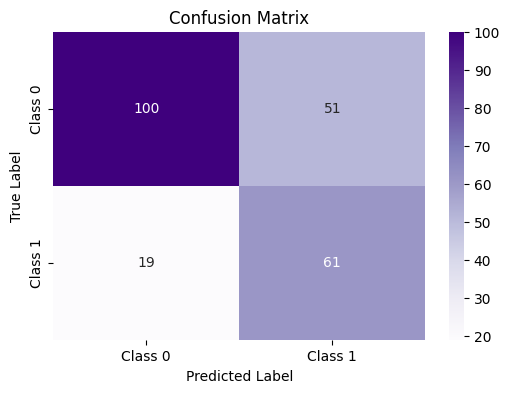

In [172]:
cm = confusion_matrix(test_labels, test_predictions)

# Define class labels
class_labels = ['Class 0', 'Class 1']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report

In [173]:
report = classification_report(test_labels, test_predictions)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.66      0.74       151
           1       0.54      0.76      0.64        80

    accuracy                           0.70       231
   macro avg       0.69      0.71      0.69       231
weighted avg       0.74      0.70      0.70       231



# ROC and AUC

AUC: 0.7123758278145695


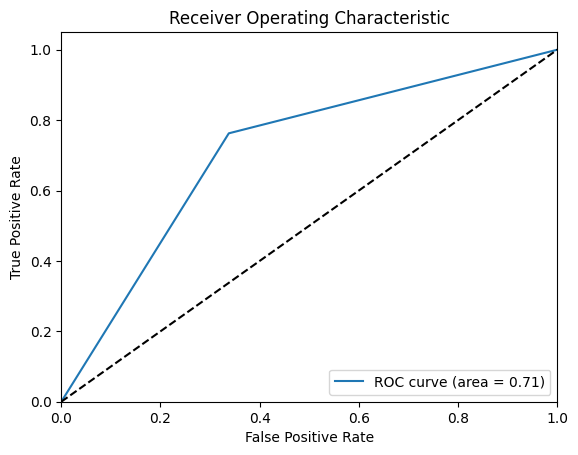

In [174]:
# Computation of ROC curve and AUC
fpr, tpr, thresholds = roc_curve(test_labels, test_predictions)
auc = roc_auc_score(test_labels, test_predictions)

print("AUC:", auc)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Cross Validation

In [175]:
scores = cross_val_score(dt, train_features, train_labels, cv=5)

# mean accuracy
mean_accuracy = scores.mean()

print("Accuracy scores for each fold:", scores)
print("Mean accuracy:", mean_accuracy)

Accuracy scores for each fold: [0.75581395 0.6744186  0.72093023 0.68604651 0.65882353]
Mean accuracy: 0.6992065663474691


## Random Forest

# Definition of a fitness function to be maximized and creation of individual and population types for the genetic algorithm

In [177]:
def fitness(individual):
    
    n_estimators, max_depth, min_samples_split = individual

    rf = RandomForestClassifier(class_weight=class_weights_dict, n_estimators=n_estimators, max_depth=max_depth, min_samples_split=min_samples_split)

    rf.fit(train_features, train_labels)

    y_val_pred = rf.predict(val_features)
    val_f1_score = f1_score(val_labels, y_val_pred)

    return val_f1_score,

if not hasattr(creator, 'FitnessMax'):
    creator.create("FitnessMax", base.Fitness, weights=(1.0,))
if not hasattr(creator, 'Individual'):
    creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("n_estimators", np.random.randint, 10, 200)
toolbox.register("max_depth", np.random.randint, 1, 10)
toolbox.register("min_samples_split", np.random.randint, 2, 10)
toolbox.register("individual", tools.initCycle, creator.Individual,
                 (toolbox.n_estimators, toolbox.max_depth, toolbox.min_samples_split), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# Registra gli operatori genetici da utilizzare dall'algoritmo genetico
toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=[10, 1, 2], up=[200, 10, 10], indpb=0.5)
toolbox.register("select", tools.selTournament, tournsize=3)

# Creating start population

In [178]:
population = toolbox.population(n=50)

# Run the genetic algorithm to find the best hyperparameters

In [179]:
result = algorithms.eaSimple(population, toolbox,
                             cxpb=0.5, mutpb=0.2,
                             ngen=10, verbose=False)

# Then we extract the best hyperparameters from genetic alghoritm

In [180]:
best_individual = tools.selBest(population, k=1)[0]
best_params = {'n_estimators': best_individual[0], 'max_depth': best_individual[1], 'min_samples_split': best_individual[2]}
print(f'Best hyperparameters: {best_params}')

Best hyperparameters: {'n_estimators': 33, 'max_depth': 6, 'min_samples_split': 4}


# Instantiate the Random Forest model using the best hyperparameters found by the genetic algorithm

In [181]:
rf = RandomForestClassifier(class_weight=class_weights_dict, n_estimators=best_params['n_estimators'], max_depth=best_params['max_depth'], min_samples_split=best_params['min_samples_split'])

# Training the model with training set

In [182]:
rf.fit(train_features, train_labels)

RandomForestClassifier(max_depth=6, min_samples_split=4, n_estimators=33)

# We using now the trained model to make predictions on test set

In [183]:
y_test_pred = rf.predict(test_features)

## Performance evaluation on the test set

In [184]:
# Accuracy
test_accuracy = accuracy_score(test_labels, y_test_pred)
print(f'Accuracy sul set di test: {test_accuracy:.2f}')

Accuracy sul set di test: 0.75


## Confusion Matrix

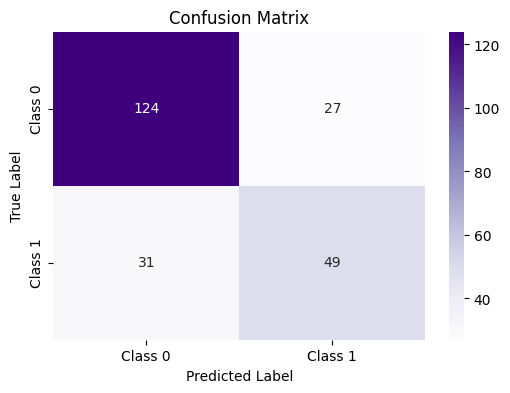

In [185]:
cm = confusion_matrix(test_labels, y_test_pred)

# Define class labels
class_labels = ['Class 0', 'Class 1']

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples',
            xticklabels=class_labels, yticklabels=class_labels)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Classification Report

In [186]:
report = classification_report(test_labels, y_test_pred)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81       151
           1       0.64      0.61      0.63        80

    accuracy                           0.75       231
   macro avg       0.72      0.72      0.72       231
weighted avg       0.75      0.75      0.75       231



# ROC and AUC

AUC: 0.7168460264900662


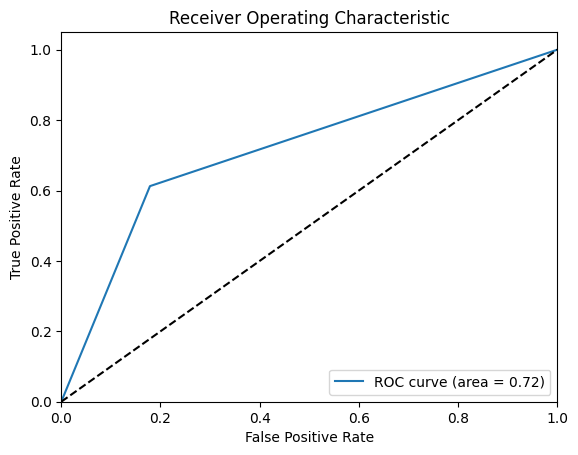

In [187]:
fpr, tpr, thresholds = roc_curve(test_labels, y_test_pred)
auc = roc_auc_score(test_labels, y_test_pred)

print("AUC:", auc)

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Cross Validation

In [188]:
scores = cross_val_score(rf, train_features, train_labels, cv=5)

mean_accuracy = scores.mean()

print("Accuracy scores for each fold:", scores)

print("Mean accuracy:", mean_accuracy)

Accuracy scores for each fold: [0.72093023 0.73255814 0.72093023 0.76744186 0.78823529]
Mean accuracy: 0.7460191518467851
